In [183]:
# Standard libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
# PyTorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import json
from PIL import Image
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
import json
import cv2

from DiffJPEG import DiffJPEG
from layers import gumbel_softmax
from helpers import create_default_qtables, return_class_name, return_class_accuracy, visualize

In [190]:
import os
import certifi
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()
os.environ["SSL_CERT_FILE"] = certifi.where()


In [184]:
from ultralytics import YOLO

# Load a pretrained YOLO model (recommended for training)
model = YOLO('../weights/yolov8s.pt')

In [185]:
# f = open("class_lists/imagenet_class_index.json")
# id_classname_json = json.load(f)
# preprocess = transforms.Compose([
#                             # transforms.CenterCrop((crop_size[1],crop_size[0])),
#                             transforms.Resize((256,256)),
#                             transforms.ToTensor(),
#                             ])
image = cv2.imread("../../data/COCO2017/train2017/000000446467.jpg")
# image = transforms.ToTensor()(image)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
norm = transforms.Normalize(mean=mean, std=std)

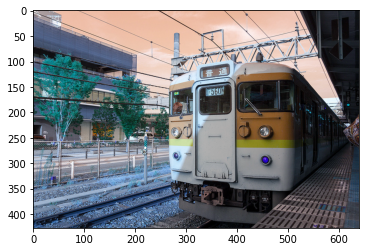

In [186]:
plt.imshow(image)

In [191]:
overrides = model.overrides
overrides['mode'] = 'train'
if not overrides.get('data'):
    raise AttributeError("Dataset required but missing, i.e. pass 'data=coco128.yaml'")
if overrides.get('resume'):
    overrides['resume'] = model.ckpt_path
model.task = overrides.get('task') or model.task
model.trainer = TASK_MAP[model.task][1](overrides=overrides, _callbacks=model.callbacks)


Ultralytics YOLOv8.0.114 🚀 Python-3.8.13 torch-1.13.0a0+d321be6 CUDA:0 (NVIDIA A40, 45634MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
yolo/engine/trainer: task=detect, mode=train, model=../weights/yolov8s.pt, data=coco.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, for

RuntimeError: Dataset 'coco.yaml' error ❌ ❌  Download failure for https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip. Retry limit reached.

In [165]:
# Setup model
from ultralytics import yolo
from ultralytics.nn.tasks import (ClassificationModel, DetectionModel, PoseModel, SegmentationModel,
                                  attempt_load_one_weight, guess_model_task, nn, yaml_model_load)

TASK_MAP = {
    'classify': [
        ClassificationModel, yolo.v8.classify.ClassificationTrainer, yolo.v8.classify.ClassificationValidator,
        yolo.v8.classify.ClassificationPredictor],
    'detect': [
        DetectionModel, yolo.v8.detect.DetectionTrainer, yolo.v8.detect.DetectionValidator,
        yolo.v8.detect.DetectionPredictor],
    'segment': [
        SegmentationModel, yolo.v8.segment.SegmentationTrainer, yolo.v8.segment.SegmentationValidator,
        yolo.v8.segment.SegmentationPredictor],
    'pose': [PoseModel, yolo.v8.pose.PoseTrainer, yolo.v8.pose.PoseValidator, yolo.v8.pose.PosePredictor]}

if not model.predictor:
    model.predictor = TASK_MAP[model.task][3](_callbacks=model.callbacks)
    model.predictor.setup_model(model=model.model, verbose=False)

In [ ]:
from ultralytics.yolo.data.dataloaders.v5loader import create_dataloader

train_dataloader = create_dataloader()

In [166]:
model.predictor.setup_source([image])

# Warmup model
if not model.predictor.done_warmup:
    model.predictor.model.warmup(imgsz=(model.predictor.dataset.bs, 3, *model.predictor.imgsz))
    model.predictor.done_warmup = True

In [179]:
preds[0].shape

torch.Size([1, 56, 5880])

In [182]:
preds[1]

([tensor([[[[  4.4625,   2.7655,   1.7449,  ...,   1.4245,   2.3957,   3.6759],
            [  5.5669,   3.1982,   1.8924,  ...,   1.5213,   2.4253,   3.5650],
            [  6.3831,   3.0307,   2.3888,  ...,   1.5300,   2.2875,   3.2307],
            ...,
            [  6.1144,   3.3571,   1.8359,  ...,   2.4404,   2.2063,   4.7637],
            [  5.8615,   3.0534,   1.7511,  ...,   0.9549,   1.6653,   4.2296],
            [  5.5621,   3.2597,   2.0266,  ...,   1.2254,   1.8661,   3.2657]],
  
           [[  4.6939,   4.6838,   2.6492,  ...,   1.6081,   2.3800,   4.3546],
            [  5.5516,   5.2594,   2.5528,  ...,   1.6259,   2.4747,   4.1061],
            [  6.3323,   5.3642,   2.9410,  ...,   1.6205,   2.3102,   3.6294],
            ...,
            [  6.0658,   5.4252,   2.5762,  ...,   2.9571,   2.6596,   4.7630],
            [  5.8135,   4.8656,   2.5599,  ...,   1.0178,   1.7454,   4.2070],
            [  5.6832,   4.9736,   3.0422,  ...,   2.0655,   2.6138,   3.7735]],
 

In [169]:
for batch in model.predictor.dataset:
    model.predictor.batch = batch
    path, im0s, vid_cap, s = batch
    im = model.predictor.preprocess(im0s)
    preds = model.predictor.model(im, augment=None, visualize=False)
    print(preds)
    results = model.predictor.postprocess(preds, im, im0s)
    print(results)

[tensor([[[8.7481e+00, 1.7183e+01, 2.4861e+01,  ..., 5.3541e+02, 5.6183e+02, 5.8662e+02],
         [8.8285e+00, 6.5098e+00, 2.5181e+00,  ..., 3.8402e+02, 3.9463e+02, 3.7956e+02],
         [3.2366e+01, 4.1609e+01, 5.8249e+01,  ..., 2.2427e+02, 2.7004e+02, 2.7068e+02],
         ...,
         [5.5539e+00, 9.1405e+00, 1.4257e+01,  ..., 5.7883e+02, 6.0329e+02, 6.1516e+02],
         [2.5669e+01, 2.4545e+01, 2.1974e+01,  ..., 4.1274e+02, 4.2213e+02, 4.3669e+02],
         [1.4572e-01, 2.2477e-01, 2.9455e-01,  ..., 6.7509e-02, 5.9385e-02, 9.6297e-02]]], device='cuda:0'), ([tensor([[[[  4.4625,   2.7655,   1.7449,  ...,   1.4245,   2.3957,   3.6759],
          [  5.5669,   3.1982,   1.8924,  ...,   1.5213,   2.4253,   3.5650],
          [  6.3831,   3.0307,   2.3888,  ...,   1.5300,   2.2875,   3.2307],
          ...,
          [  6.1144,   3.3571,   1.8359,  ...,   2.4404,   2.2063,   4.7637],
          [  5.8615,   3.0534,   1.7511,  ...,   0.9549,   1.6653,   4.2296],
          [  5.5621,   3

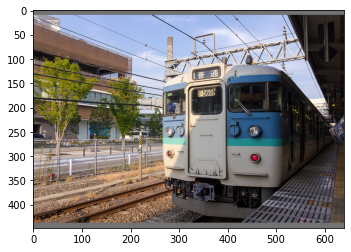

In [147]:
plt.imshow(im[0].permute(1,2,0).detach().cpu().numpy())

''

In [ ]:
"""Streams real-time inference on camera feed and saves results to file."""

self.seen, self.windows, self.batch, profilers = 0, [], None, (ops.Profile(), ops.Profile(), ops.Profile())
self.run_callbacks('on_predict_start')
for batch in self.dataset:
    self.run_callbacks('on_predict_batch_start')
    self.batch = batch
    path, im0s, vid_cap, s = batch
    visualize = increment_path(self.save_dir / Path(path[0]).stem,
                               mkdir=True) if self.args.visualize and (not self.source_type.tensor) else False

    # Preprocess
    with profilers[0]:
        im = self.preprocess(im0s)

    # Inference
    with profilers[1]:
        preds = self.model(im, augment=self.args.augment, visualize=visualize)

    # Postprocess
    with profilers[2]:
        self.results = self.postprocess(preds, im, im0s)
    self.run_callbacks('on_predict_postprocess_end')

    # Visualize, save, write results
    n = len(im0s)
    for i in range(n):
        self.results[i].speed = {
            'preprocess': profilers[0].dt * 1E3 / n,
            'inference': profilers[1].dt * 1E3 / n,
            'postprocess': profilers[2].dt * 1E3 / n}
        if self.source_type.tensor:  # skip write, show and plot operations if input is raw tensor
            continue
        p, im0 = path[i], im0s[i].copy()
        p = Path(p)

        if self.args.verbose or self.args.save or self.args.save_txt or self.args.show:
            s += self.write_results(i, self.results, (p, im, im0))

        if self.args.show and self.plotted_img is not None:
            self.show(p)

        if self.args.save and self.plotted_img is not None:
            self.save_preds(vid_cap, i, str(self.save_dir / p.name))
    self.run_callbacks('on_predict_batch_end')
    yield from self.results

    # Print time (inference-only)
    if self.args.verbose:
        LOGGER.info(f'{s}{profilers[1].dt * 1E3:.1f}ms')

# Release assets
if isinstance(self.vid_writer[-1], cv2.VideoWriter):
    self.vid_writer[-1].release()  # release final video writer

# Print results
if self.args.verbose and self.seen:
    t = tuple(x.t / self.seen * 1E3 for x in profilers)  # speeds per image
    LOGGER.info(f'Speed: %.1fms preprocess, %.1fms inference, %.1fms postprocess per image at shape '
                f'{(1, 3, *self.imgsz)}' % t)
if self.args.save or self.args.save_txt or self.args.save_crop:
    nl = len(list(self.save_dir.glob('labels/*.txt')))  # number of labels
    s = f"\n{nl} label{'s' * (nl > 1)} saved to {self.save_dir / 'labels'}" if self.args.save_txt else ''
    LOGGER.info(f"Results saved to {colorstr('bold', self.save_dir)}{s}")

self.run_callbacks('on_predict_end')

([tensor([[[[  5.2986,   3.4687,   2.7004,  ...,   1.3218,   1.9816,   4.1524],
            [  8.5114,   3.7178,   2.5559,  ...,   1.2648,   2.1253,   6.0176],
            [  8.5100,   4.1749,   2.1742,  ...,   1.3193,   3.4898,   7.9013],
            ...,
            [  8.7682,   6.2308,   3.4277,  ...,   3.2595,   2.5828,   5.2745],
            [  7.3594,   4.3546,   2.5580,  ...,   0.8712,   2.0310,   5.0612],
            [  7.1934,   3.9680,   2.3897,  ...,  -0.0973,   0.9193,   3.4591]],
  
           [[  5.5847,   4.7890,   3.0263,  ...,   1.2439,   2.2542,   3.7968],
            [  8.4189,   6.4767,   3.5021,  ...,   1.6035,   2.5131,   5.5722],
            [  8.4381,   7.6561,   3.8392,  ...,   2.4303,   3.6522,   7.7216],
            ...,
            [  8.7276,   7.5864,   4.1490,  ...,   4.4947,   3.6044,   5.2397],
            [  7.3747,   6.2507,   2.9792,  ...,   1.3122,   2.1344,   4.6592],
            [  7.3377,   5.6974,   2.8223,  ...,  -0.4813,   0.7416,   2.8937]],
 

In [20]:
results[0].boxes.data

tensor([[2.6519e+02, 9.8263e+01, 6.2212e+02, 4.1582e+02, 9.1564e-01, 6.0000e+00],
        [6.0834e+02, 2.0333e+02, 6.3959e+02, 2.6980e+02, 6.5023e-01, 6.0000e+00],
        [2.7607e-01, 2.4364e+02, 2.5021e+01, 2.5447e+02, 4.1226e-01, 2.0000e+00]], device='cuda:0')

In [ ]:
import os
import certifi
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()
os.environ["SSL_CERT_FILE"] = certifi.where()

In [45]:
root = r"../../data/imagenette2/train"
val_root = r"../../data/imagenette2/val"
device = "cuda"

In [17]:
resnet = torchvision.models.resnet50(pretrained=False) 
#Just use pretrained = True if you can download the weights
resnet.load_state_dict(torch.load('../weights/resnet50.pth')) 
resnet.eval()
for param in resnet.parameters():
    param.requires_grad = False
print()

In [9]:
f = open("class_lists/imagenet_class_index.json")
id_classname_json = json.load(f)
preprocess = transforms.Compose([
                            # transforms.CenterCrop((crop_size[1],crop_size[0])),
                            transforms.Resize((256,256)),
                            transforms.ToTensor(),
                            ])
image = preprocess(Image.open("sample_imgs/panda.jpg"))
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
norm = transforms.Normalize(mean=mean, std=std)

3.333333333333333


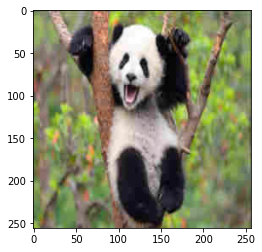

In [19]:
y_table, c_table = create_default_qtables()
JPEGCompress = DiffJPEG(image.shape[1], image.shape[2], differentiable=True, quality=15)
compressed_image = JPEGCompress(image.unsqueeze(0), y_table, c_table)[0]
plt.imshow(transforms.ToPILImage()(compressed_image))

In [20]:
with torch.no_grad():
    predictions = resnet(norm(image).unsqueeze(0))
    (target_class, target_dim) = return_class_name(id_classname_json, predictions)
    print(target_class)
    acc_of_original = return_class_accuracy(predictions, target_dim)
    
    predictions = resnet(norm(compressed_image).unsqueeze(0))
    acc_of_compressed = return_class_accuracy(predictions, target_dim)
    print(acc_of_original, acc_of_compressed)
    # predictied_class = return_class_name(predictions)[0]

giant_panda
65.0 52.0


In [48]:
def dataset_with_indices(cls):
    """
    Modifies the given Dataset class to return a tuple data, target, index
    instead of just data, target.
    """

    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index

    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })

DatasetWIdx = dataset_with_indices(torchvision.datasets.ImageFolder)
train_dataset = DatasetWIdx(root, transform = preprocess)

# train_dataset = torchvision.datasets.ImageFolder("../../data/imagenette2/train", transform = preprocess)
train_dataset.class_to_idx = {
 'n01440764': 0,
 'n02102040': 217,
 'n02979186': 482,
 'n03000684': 491,
 'n03028079': 497,
 'n03394916': 566,
 'n03417042': 569,
 'n03425413': 571,
 'n03445777': 574,
 'n03888257': 701}
train_dataset.samples = train_dataset.make_dataset(train_dataset.root, 
                                                   train_dataset.class_to_idx, 
                                                   train_dataset.extensions, 
                                                   None)


val_dataset = DatasetWIdx(val_root, transform = preprocess)
val_dataset.class_to_idx = {
 'n01440764': 0,
 'n02102040': 217,
 'n02979186': 482,
 'n03000684': 491,
 'n03028079': 497,
 'n03394916': 566,
 'n03417042': 569,
 'n03425413': 571,
 'n03445777': 574,
 'n03888257': 701}
val_dataset.samples = val_dataset.make_dataset(val_dataset.root, 
                                               val_dataset.class_to_idx, 
                                               val_dataset.extensions, 
                                               None)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = 256)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=256)

## Calculate performance with default Q-Tables

In [37]:
y_table, c_table = create_default_qtables()
y_table, c_table = y_table.to(device), c_table.to(device)
train_acc = 0

resnet = resnet.to("cuda")
for (image, labels, idx) in tqdm(train_loader):
    with torch.no_grad():
        image = image.to(device)
        labels = labels.to(device)
        JPEGCompress = JPEGCompress.to(device)
        compressed_image = JPEGCompress(image, y_table, c_table)
        logits = resnet(norm(compressed_image).to("cuda"))
        (target_class, target_dim) = return_class_name(id_classname_json, logits[-1].unsqueeze(0))
        acc = return_class_accuracy(logits[-1].unsqueeze(0), target_dim)
        train_acc = train_acc + (logits.argmax(dim=1) == labels.to("cuda")).sum()

print("Accuracy with default Q-Table:", train_acc/len(train_dataset))

100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

Accuracy with default Q-Table: tensor(0.6857, device='cuda:0')


## Perturbing the Q-Tables to get better results

In [38]:
max_q_value = 128

JPEGCompress = JPEGCompress.to(device)

y_table, c_table = create_default_qtables()
# y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor) - 1, num_classes=255).type(torch.FloatTensor)
# c_table_1hot = torch.nn.functional.one_hot(c_table.type(torch.LongTensor) - 1, num_classes=255).type(torch.FloatTensor)
y_table_1hot = torch.nn.functional.one_hot(torch.ones((8,8), dtype=torch.LongTensor.dtype), 
                                           num_classes=max_q_value-1).type(torch.FloatTensor).to(device)
c_table_1hot = torch.nn.functional.one_hot(torch.ones((8,8), dtype=torch.LongTensor.dtype), 
                                           num_classes=max_q_value-1).type(torch.FloatTensor).to(device) 

y_table_1hot.requires_grad = True
c_table_1hot.requires_grad = True

optimizer = torch.optim.NAdam([
    y_table_1hot, 
    c_table_1hot
], lr=0.1)

ones_table = torch.ones((8,8)).to(device)
ones_table.requires_grad = False

categorical_values_table = torch.arange(max_q_value-1).reshape(1,-1).to(device) + 1 
# + 1 to avoid divide by zero errors when quantizing
categorical_values_table.requires_grad = False

# print(y_table.requires_grad)

loss = torch.nn.MSELoss()
qloss = torch.nn.MSELoss(reduction='mean')

# sanity check to ensure that gradients are flowing and changing the 1 hot y_table 
best_y_1hot = deepcopy(y_table_1hot) 

best_y_table = deepcopy(y_table)
best_c_table = deepcopy(c_table)
best_loss = np.inf

ori_train_acc = 0.0

initial_temperature = 0.5
temperature_anneal_rate = 0.1

# Hyperparam alpha to balance between maximizing Quantization and 
# minimizing euclidean dist against uncompressed logits
alpha = torch.tensor((1e-6)) 
alpha.requires_grad=True

resnet = resnet.to(device)

logits_uncompressed = torch.zeros((len(train_dataset), resnet.fc.out_features)).to(device)
for (image, labels, idx) in tqdm(train_loader):
    image = image.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        ori_logits = resnet(norm(image))
        logits_uncompressed[idx] = ori_logits
        (target_class, target_dim) = return_class_name(id_classname_json, ori_logits[-1].unsqueeze(0))
        original_acc = return_class_accuracy(ori_logits[-1].unsqueeze(0), target_dim)
        ori_train_acc = ori_train_acc + (ori_logits.argmax(dim=1) == labels).sum()
ori_train_acc = ori_train_acc / len(train_dataset)        

for epoch in range(50):
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_val_loss = 0.0
    running_val_acc = 0.0
    
    temperature = max(0.001, initial_temperature*np.exp(-temperature_anneal_rate*epoch))
    
    for (image, labels, idx) in tqdm(train_loader):  
        image = image.to(device)
        labels = labels.to(device)
        
        # y_table = gumbel_softmax(y_table_1hot.view(1, -1, 255), temperature, True) * categorical_values_table
        # c_table = gumbel_softmax(c_table_1hot.view(1, -1, 255), temperature, True) * categorical_values_table
        
        y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, max_q_value-1)/temperature, dim=2) * categorical_values_table
        c_table = torch.nn.functional.softmax(c_table_1hot.view(1, -1, max_q_value-1)/temperature, dim=2) * categorical_values_table
        
        y_table = y_table.sum(dim=2).reshape(8,8)
        c_table = c_table.sum(dim=2).reshape(8,8)

        # print(y_table)
        
        compressed_image = JPEGCompress(image, y_table, c_table)
        data = norm(compressed_image)
        logits = resnet(data)
        pred = logits.argmax(dim=1)
        
        ori_logits = logits_uncompressed[idx]
        
        loss_minimize = loss(logits, ori_logits) #we try to minimize this loss
        loss_maximize = (- qloss(y_table, ones_table) - qloss(c_table, ones_table))
        total_loss = (1-alpha)*loss_minimize + (alpha)* loss_maximize #total loss to be optimized

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # print((y_table_1hot == best_y_1hot).all())
        
        running_train_loss = running_train_loss + total_loss.detach().cpu() * image.shape[0]
        running_train_acc = running_train_acc + (pred == labels).sum()
            
    if running_train_loss/len(train_dataset) < best_loss:
        best_y_table = y_table
        best_c_table = c_table
        best_loss = running_train_loss/len(train_dataset)
        torch.save({"y_table" : y_table,
                   "c_table" : c_table,
                    "optimizer" : optimizer.state_dict(),
                   }, "best_ckpt.tar")
        
    if epoch % 10 == 0 and epoch > 0:
        torch.save({"y_table" : y_table,
           "c_table" : c_table,
            "optimizer" : optimizer.state_dict(),
           }, "epoch_{0}.tar".format(epoch))
        
    print("epoch {0}, training_loss: {1}, training_acc: {2}, ori_train_acc: {3}, logit loss: {4}, q table loss: {5}".format(
        epoch, 
        round(running_train_loss.item()/len(train_dataset), 5), 
        round(running_train_acc.item()/len(train_dataset)*100, 2),
        round(ori_train_acc.item()*100, 2),
        round(loss_minimize.item(), 5), 
        round(loss_maximize.item(), 5)
    ))
        

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


epoch 0, training_loss: 4.03006, training_acc: 21.43, ori_train_acc: 82.86, logit loss: 4.03727, q table loss: -7207.28027


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 1, training_loss: 3.76187, training_acc: 30.0, ori_train_acc: 82.86, logit loss: 3.76956, q table loss: -7685.2373


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 2, training_loss: 3.5651, training_acc: 31.43, ori_train_acc: 82.86, logit loss: 3.57317, q table loss: -8062.87695


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 3, training_loss: 3.33458, training_acc: 37.14, ori_train_acc: 82.86, logit loss: 3.34326, q table loss: -8679.80469


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


epoch 4, training_loss: 3.02729, training_acc: 41.43, ori_train_acc: 82.86, logit loss: 3.03673, q table loss: -9434.91504


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 5, training_loss: 2.84544, training_acc: 45.71, ori_train_acc: 82.86, logit loss: 2.85574, q table loss: -10304.75


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


epoch 6, training_loss: 2.71083, training_acc: 50.0, ori_train_acc: 82.86, logit loss: 2.72211, q table loss: -11280.13086


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 7, training_loss: 2.45692, training_acc: 52.86, ori_train_acc: 82.86, logit loss: 2.46916, q table loss: -12236.61035


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


epoch 8, training_loss: 2.23944, training_acc: 58.57, ori_train_acc: 82.86, logit loss: 2.25267, q table loss: -13220.87695


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 9, training_loss: 1.96757, training_acc: 60.0, ori_train_acc: 82.86, logit loss: 1.98171, q table loss: -14137.50293


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 10, training_loss: 1.60647, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.62133, q table loss: -14853.49512


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


epoch 11, training_loss: 1.30025, training_acc: 72.86, ori_train_acc: 82.86, logit loss: 1.31579, q table loss: -15540.84277


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


epoch 12, training_loss: 1.20049, training_acc: 72.86, ori_train_acc: 82.86, logit loss: 1.21661, q table loss: -16120.51367


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 13, training_loss: 1.02406, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.0407, q table loss: -16643.35156


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


epoch 14, training_loss: 0.92694, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 0.94402, q table loss: -17078.80859


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


epoch 15, training_loss: 0.86486, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 0.8823, q table loss: -17440.23438


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


epoch 16, training_loss: 0.84622, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 0.86399, q table loss: -17770.91602


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 17, training_loss: 0.89994, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 0.91798, q table loss: -18045.0


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


epoch 18, training_loss: 0.86665, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 0.88484, q table loss: -18191.69141


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 19, training_loss: 0.85954, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 0.87794, q table loss: -18403.23438


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


epoch 20, training_loss: 0.90325, training_acc: 74.29, ori_train_acc: 82.86, logit loss: 0.92183, q table loss: -18573.39258


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 21, training_loss: 0.94592, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 0.96457, q table loss: -18644.63281


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 22, training_loss: 0.93641, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 0.9551, q table loss: -18689.23047


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 23, training_loss: 0.95334, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 0.97209, q table loss: -18753.97656


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 24, training_loss: 0.96572, training_acc: 78.57, ori_train_acc: 82.86, logit loss: 0.98453, q table loss: -18805.17188


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


epoch 25, training_loss: 1.06943, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08828, q table loss: -18842.5918


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 26, training_loss: 1.02468, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 1.04356, q table loss: -18875.18359


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 27, training_loss: 1.0457, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 1.06457, q table loss: -18868.21094


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


epoch 28, training_loss: 1.03025, training_acc: 74.29, ori_train_acc: 82.86, logit loss: 1.04925, q table loss: -18993.99219


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


epoch 29, training_loss: 1.04771, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 1.06678, q table loss: -19071.07812


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


epoch 30, training_loss: 1.05212, training_acc: 74.29, ori_train_acc: 82.86, logit loss: 1.07118, q table loss: -19054.70898


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


epoch 31, training_loss: 1.07592, training_acc: 74.29, ori_train_acc: 82.86, logit loss: 1.09507, q table loss: -19153.90234


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


epoch 32, training_loss: 1.03913, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 1.05829, q table loss: -19159.22461


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 33, training_loss: 1.04451, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 1.06367, q table loss: -19158.19141


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


epoch 34, training_loss: 1.02248, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 1.04164, q table loss: -19163.23047


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 35, training_loss: 1.06886, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08802, q table loss: -19162.49414


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 36, training_loss: 1.06453, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08369, q table loss: -19157.08789


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 37, training_loss: 1.05336, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.07251, q table loss: -19155.16797


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 38, training_loss: 1.06145, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08061, q table loss: -19158.99805


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


epoch 39, training_loss: 1.0568, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.07596, q table loss: -19163.65234


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


epoch 40, training_loss: 1.0562, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.07537, q table loss: -19168.61328


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 41, training_loss: 1.05735, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 1.07653, q table loss: -19178.09766


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


epoch 42, training_loss: 1.06241, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08159, q table loss: -19181.42969


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 43, training_loss: 1.05933, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.07852, q table loss: -19183.38672


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 44, training_loss: 1.0629, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08209, q table loss: -19184.25781


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 45, training_loss: 1.06242, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 1.0816, q table loss: -19183.23828


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 46, training_loss: 1.06319, training_acc: 77.14, ori_train_acc: 82.86, logit loss: 1.08237, q table loss: -19180.01172


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


epoch 47, training_loss: 1.06323, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08241, q table loss: -19176.23047


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


epoch 48, training_loss: 1.06342, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08259, q table loss: -19172.83203


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 49, training_loss: 1.06047, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.07964, q table loss: -19170.81836


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 50, training_loss: 1.06374, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08291, q table loss: -19168.81055


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 51, training_loss: 1.06405, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08321, q table loss: -19167.98828


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


epoch 52, training_loss: 1.0641, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08327, q table loss: -19167.58789


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 53, training_loss: 1.06426, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08343, q table loss: -19167.39062


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


epoch 54, training_loss: 1.06361, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08278, q table loss: -19167.20508


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 55, training_loss: 1.06396, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08313, q table loss: -19167.42578


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


epoch 56, training_loss: 1.06268, training_acc: 75.71, ori_train_acc: 82.86, logit loss: 1.08184, q table loss: -19166.89258


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [28]:
temperature

0.2744058180470132

In [29]:
y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, 127)/temperature, dim=2) * categorical_values_table
c_table = torch.nn.functional.softmax(c_table_1hot.view(1, -1, 127)/temperature, dim=2) * categorical_values_table

y_table = y_table.sum(dim=2).reshape(8,8)
c_table = c_table.sum(dim=2).reshape(8,8)


print("y_table\n", y_table)
print("c_table\n", c_table)

y_table
 tensor([[ 27.7852,   1.9919,   1.9945,   3.0024,   1.0000,   1.0000,  43.9778,
           1.0000],
        [  1.9993,  16.0006,  20.0009,  24.0561,  22.0049,  26.0000,  34.9975,
          36.9951],
        [  7.0638,  23.9971,  23.9971,  24.0038,  23.9972,  25.0023,  27.9994,
         126.9999],
        [  5.0020,  27.0109,  25.9873,  21.9956,  20.0047,  23.0092,  26.9904,
         127.0000],
        [  1.0000,  29.0057,  26.0058,  21.9269,  23.0089,  22.0004, 127.0000,
         127.0000],
        [ 74.9917,  35.0229,  27.9584,  26.0064,  27.9943, 127.0000, 127.0000,
         127.0000],
        [126.9997, 126.9998,  40.9676,  30.9972, 127.0000, 127.0000, 127.0000,
         127.0000],
        [126.9999, 126.9999, 127.0000, 127.0000, 127.0000, 127.0000, 127.0000,
         127.0000]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
c_table
 tensor([[ 15.9852,  23.0061,  22.9996,  24.9524,  24.9387, 126.9999, 127.0000,
         126.9999],
        [ 31.0097,  24.0027,  19.0014,  

In [30]:
# Calculate accuracy if y_table and c_table were integers
y_table = y_table_1hot.argmax(dim=2) +1
c_table = c_table_1hot.argmax(dim=2) +1

train_acc = 0
for (image, labels, idx) in tqdm(train_loader):
    with torch.no_grad():
        image = image.to(device)
        labels = labels.to(device)
        JPEGCompress = JPEGCompress.to(device)
        compressed_image = JPEGCompress(image, y_table, c_table)
        logits = resnet(norm(compressed_image))
        (target_class, target_dim) = return_class_name(id_classname_json, logits[-1].unsqueeze(0))
        acc = return_class_accuracy(logits[-1].unsqueeze(0), target_dim)
        train_acc = train_acc + (logits.argmax(dim=1) == labels).sum()

print(train_acc/len(train_dataset))

100%|██████████| 37/37 [02:28<00:00,  4.01s/it]

tensor(0.7422, device='cuda:0')


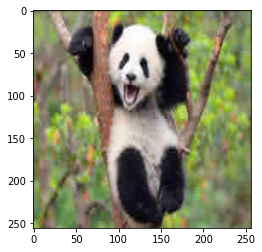

In [91]:
img = preprocess(Image.open("sample_imgs/panda.jpg"))
compressed_image = JPEGCompress(img.unsqueeze(0), y_table, c_table)[0]
# plt.figure(0, figsize=(20,20))
plt.imshow(transforms.ToPILImage()(compressed_image))

In [59]:
y_table.flatten()

tensor([ 16,  12,  14,  14,  18,  24,  49,  72,  11,  12,  13,  17,  22,  35,
         64,  92,  10,  14,  16,  22,  37,  55,  78,  95,  16,  19,  24,  29,
         56,  64,  87,  98,  24,  26,  40,  51,  68,  81, 103, 112,  40,  58,
         57,  87, 109, 104, 121, 100,  51,  60,  69,  80, 103, 113, 120, 103,
         61,  55,  56,  62,  77,  92, 101,  99])

In [31]:
# check file size
import os
from io  import BytesIO
total_size_ori = 0

for folder in os.listdir(root):
    for file in os.listdir(os.path.join(root, folder)):
        total_size_ori += os.stat(os.path.join(root, folder, file)).st_size
        
print("total size originally:", total_size_ori)

qtable = {0: y_table.flatten().type(torch.LongTensor).tolist(), 1: c_table.flatten().type(torch.LongTensor).tolist()}
f_buffer = BytesIO()
total_size_aft = 0

for folder in os.listdir(root):
    for file in os.listdir(os.path.join(root, folder)):
        im = Image.open(os.path.join(root, folder, file))
        im.save(f_buffer, 'JPEG', qtables=qtable)
        total_size_aft += f_buffer.getbuffer().nbytes
        f_buffer.seek(0)
        f_buffer.truncate(0)

print("total size after:", total_size_aft)
print("compression_ratio:", round(total_size_aft/float(total_size_ori), 2))

total size originally: 1104723940
total size after: 431887376
compression_ratio: 0.39


In [62]:

im = Image.open("sample_imgs/panda.jpg")
qtable = {0: y_table.flatten().type(torch.LongTensor).tolist(), 1: c_table.flatten().type(torch.LongTensor).tolist()}
# f_buffer = BytesIO()
im.save(f_buffer, 'JPEG', qtables=qtable)

In [55]:

im = Image.open("test.jpg")
print(np.array(im.quantization[0]).reshape(8,8), "\n", np.array(im.quantization[1]).reshape(8,8))

[[  2   1   2   2   1   1   2   2]
 [  2   2   2   2   2   2   2 255]
 [  2   2   2   2   2   2 255 255]
 [  2   2   2   2   2 255 255 255]
 [  2   2   2   2   2 255 255 255]
 [  2   2   2   2   2   2 255 255]
 [  2   2 255   2 255 255 255 255]
 [  2 255 255 255 255 255 255 255]] 
 [[  2   2   2 255 255 255 255 255]
 [  2   2   2 255 255 255 255 255]
 [  2   2 255 255 255 255 255 255]
 [  2 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255]]


In [58]:
import os
print(os.stat('sample_imgs/panda.jpg').st_size, os.stat('test.jpg').st_size)

69691 119052


## Section for debugging

In [23]:
y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, 255)/0.01, dim=2) * categorical_values_table
y_table = y_table.sum(dim=2).reshape(8,8)
y_table.type(torch.LongTensor)

tensor([[2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2]])

In [123]:
y_table, c_table = create_default_qtables()
y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor) - 1, num_classes=255).type(torch.FloatTensor)
y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, 255)*10.0, dim=2) * categorical_values_table
        
y_table = y_table.sum(dim=2).reshape(8,8)
y_table

tensor([[ 17.2818,  13.3276,  15.3047,  15.3047,  19.2589,  25.1903,  49.9041,
          72.6409],
        [ 12.3391,  13.3276,  14.3162,  18.2704,  23.2132,  36.0644,  64.7325,
          92.4120],
        [ 11.3505,  15.3047,  17.2818,  23.2132,  38.0415,  55.8355,  78.5722,
          95.3777],
        [ 17.2818,  20.2475,  25.1903,  30.1330,  56.8240,  64.7325,  87.4692,
          98.3433],
        [ 25.1903,  27.1674,  41.0071,  51.8812,  68.6867,  81.5379, 103.2861,
         112.1831],
        [ 41.0071,  58.8011,  57.8126,  87.4692, 109.2174, 104.2747, 121.0801,
         100.3204],
        [ 51.8812,  60.7782,  69.6752,  80.5493, 103.2861, 113.1716, 120.0915,
         103.2861],
        [ 61.7668,  55.8355,  56.8240,  62.7553,  77.5836,  92.4120, 101.3090,
          99.3319]])

In [88]:
gumbel_softmax(y_table_1hot.view(1, -1, 255)*10.0, temperature, True).argmax(dim=2)

tensor([[ 16,  12,  14,  14,  18,  24,  49,  72,  11,  12,  13,  17,  22,  35,
          64,  92,  10,  14,  16,  22,  37,  55,  78,  95,  16,  19,  24,  29,
          56,  64,  87,  98,  24,  26,  40,  51,  68,  81, 103, 112,  40,  58,
          57,  87, 109, 104, 121, 100,  51,  60,  69,  80, 103, 113, 120, 103,
          61,  55,  56,  62,  77,  92, 101,  99]])

In [24]:
y_table = gumbel_softmax(y_table_1hot.view(1, -1, 255), 0.01, True) * categorical_values_table
y_table = y_table.sum(dim=2).reshape(8,8)
y_table

tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.]], grad_fn=<ReshapeAliasBackward0>)

In [29]:
y_table, c_table = create_default_qtables()
y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor), num_classes=255).type(torch.FloatTensor) * 5
c_table_1hot = torch.nn.functional.one_hot(c_table.type(torch.LongTensor), num_classes=255).type(torch.FloatTensor) * 5

In [29]:
y_table_1hot.view(-1,255)

torch.Size([64, 255])

In [36]:
gumbel_softmax(y_table_1hot.view(1, -1, 255)*5, 0.1, True).argmax(dim=2).reshape(8,8)

tensor([[ 16,  12,  14,  14,  18,  24,  49,  72],
        [ 11,  12,  13,  17,  22,  35,  64,  92],
        [ 10,  14,  16,  22,  37,  55,  78,  95],
        [ 16,  19,  24,  29,  56,  64,  87,  98],
        [ 24,  26,  40,  51,  68,  81, 103, 112],
        [ 40,  58,  57,  87, 109, 104, 121, 100],
        [ 51,  60,  69,  80, 103, 113, 120, 103],
        [ 61,  55,  56,  62,  77,  92, 101,  99]])

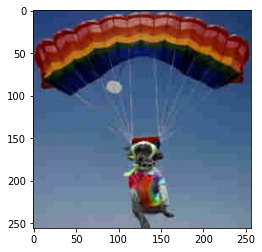

In [38]:
compressed = JPEGCompress(image, torch.round(y_table), torch.round(c_table))[1]
plt.imshow(transforms.ToPILImage()(compressed))

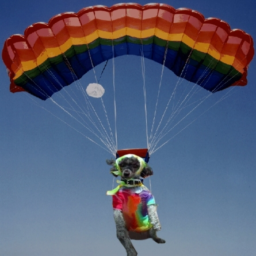

In [36]:
transforms.ToPILImage()(image[1])

In [39]:
torch.save({"y_table" : y_table,
           "c_table" : c_table,
            "optimizer" : optimizer.state_dict(),
           }, "best_ckpt.tar")

In [39]:
t = torch.load("epoch_50.tar")
y_table = t["y_table"].type(torch.LongTensor)
c_table = t["c_table"].type(torch.LongTensor)



In [50]:
t = torch.load("best_ckpt_train.tar")
y_table = t["y_table"].type(torch.LongTensor)
c_table = t["c_table"].type(torch.LongTensor)
y_table, c_table = y_table.to(device), c_table.to(device)
resnet = resnet.to(device)

acc = 0
for (image, labels, idx) in tqdm(val_loader):
    with torch.no_grad():
        image = image.to(device)
        labels = labels.to(device)
        JPEGCompress = JPEGCompress.to(device)
        compressed_image = JPEGCompress(image, y_table, c_table)
        logits = resnet(norm(compressed_image))
        (target_class, target_dim) = return_class_name(id_classname_json, logits[-1].unsqueeze(0))
        acc = acc + (logits.argmax(dim=1) == labels).sum()

print(acc/len(val_dataset))

100%|██████████| 16/16 [01:00<00:00,  3.75s/it]

tensor(0.7343, device='cuda:0')


In [49]:

y_table, c_table = create_default_qtables()
y_table, c_table = y_table.to(device), c_table.to(device)
resnet = resnet.to(device)

acc = 0
for (image, labels, idx) in tqdm(val_loader):
    with torch.no_grad():
        image = image.to(device)
        labels = labels.to(device)
        JPEGCompress = JPEGCompress.to(device)
        compressed_image = JPEGCompress(image, y_table, c_table)
        logits = resnet(norm(compressed_image))
        (target_class, target_dim) = return_class_name(id_classname_json, logits[-1].unsqueeze(0))
        acc = acc + (logits.argmax(dim=1) == labels).sum()

print(acc/len(val_dataset))

100%|██████████| 16/16 [01:51<00:00,  6.94s/it]

tensor(0.7223, device='cuda:0')


In [51]:
# check file size
import os
from io  import BytesIO
total_size_ori = 0

for folder in os.listdir(val_root):
    for file in os.listdir(os.path.join(val_root, folder)):
        total_size_ori += os.stat(os.path.join(val_root, folder, file)).st_size
        
print("total size originally:", total_size_ori)

qtable = {0: y_table.flatten().type(torch.LongTensor).tolist(), 1: c_table.flatten().type(torch.LongTensor).tolist()}
f_buffer = BytesIO()
total_size_aft = 0

for folder in os.listdir(val_root):
    for file in os.listdir(os.path.join(val_root, folder)):
        im = Image.open(os.path.join(val_root, folder, file))
        im.save(f_buffer, 'JPEG', qtables=qtable)
        total_size_aft += f_buffer.getbuffer().nbytes
        f_buffer.seek(0)
        f_buffer.truncate(0)

print("total size after:", total_size_aft)
print("compression_ratio:", round(total_size_aft/float(total_size_ori), 2))

total size originally: 463952115
total size after: 190926219
compression_ratio: 0.41
